In [1]:
import matplotlib.pyplot as plt   
import seaborn as sns; sns.set()  
import numpy as np  
import pandas as pd 
import scipy.cluster.hierarchy as shc  
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering

In [2]:
# Lese CSV-Datei ein 
klima_data = pd.read_csv('datasets/raumklima.csv',sep=';', header=0)  

# Merkmale/Variablen Feuchtigk. und Temp. separat speichern
X = klima_data.iloc[:,[0,1]].copy() 

# Wahre Zuordnung zu den Kategorien speichern
cluster_true=klima_data.iloc[:,2].copy() 

# Zeige ausgewählte Zeilen zur Kontrolle an 
klima_data.head(10)

,Feuchte,Temp,Cluster
0,42,21,behaglich
1,45,19,behaglich
2,52,19,behaglich
3,55,21,behaglich
4,53,22,behaglich
5,69,23,zu feucht
6,80,21,zu feucht
7,81,23,zu feucht
8,73,25,zu feucht
9,75,25,zu feucht


<class 'numpy.ndarray'>


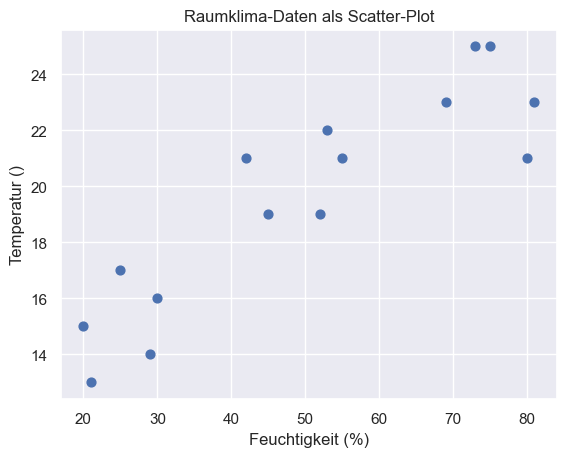

In [3]:
X = np.array(X) # Typkonvertierung: DataFrame->Array  
print(type(X))  
# Daten visualisieren  
plt.scatter(X[:,0], X[:,1],s=40);  
plt.title('Raumklima-Daten als Scatter-Plot')  
plt.xlabel('Feuchtigkeit (%)');plt.ylabel('Temperatur ()');  

In [4]:
#Anzahl der Zentren festlegen
kmeans = KMeans(n_clusters=3) 

# Vorhersage mittels K-Means-Verfahren
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# vorhergesagte Zuordnungen der Merkmalskombinationen zu den geschätzten Zentren
y_kmeans

array([2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

Merkmalswerte der Zentren:
[[75.6 23.4]
 [25.  15. ]
 [49.4 20.4]]


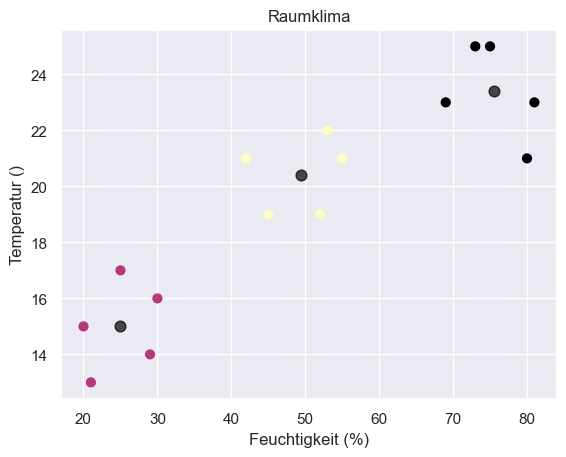

In [5]:
# Daten visualisieren: Merkmale
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=40, cmap='magma')

# Daten visualisieren: Zentren
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=60, alpha=0.7);

plt.title("Raumklima")
plt.xlabel('Feuchtigkeit (%)');plt.ylabel('Temperatur ()'); 

# Merkmalswerte der Zentren ausgeben
print('Merkmalswerte der Zentren:')  
print(centers) 

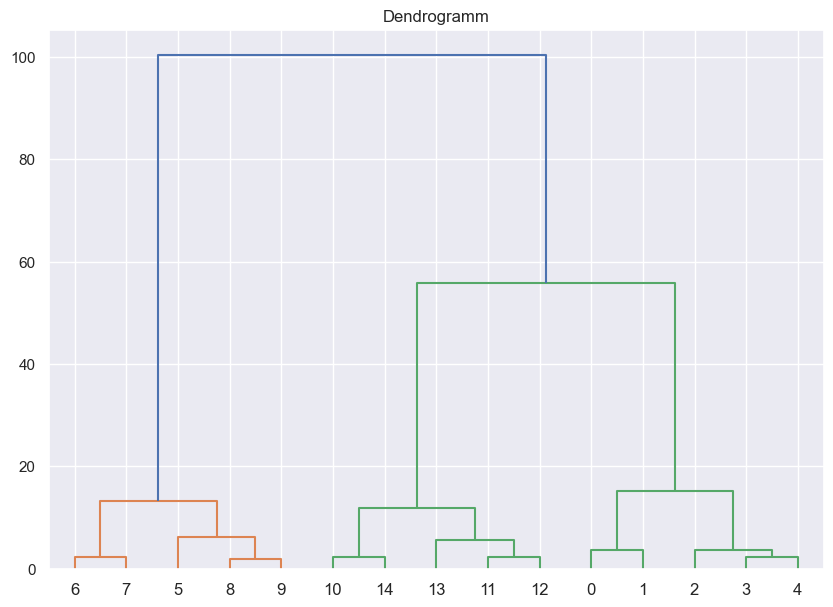

In [6]:
plt.figure(figsize=(10, 7))
plt.title("Dendrogramm")
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [7]:
# hierarchisches Modell festlegen, inkl. Anzahl der Cluster
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

# Vorhersage mittels des hierarchischen Modells
cluster = cluster.fit(X)
y_cluster = cluster.fit_predict(X)

# vorhergesagte Zuordnungen der Merkmalskombinationen zu den geschätzten Zentren
y_cluster #or:
# print(cluster.labels_)

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int64)

Text(0, 0.5, 'Temperatur(Celsius)')

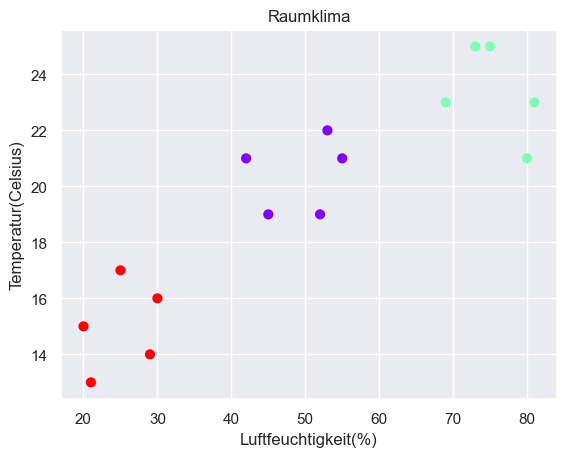

In [8]:
# Daten visualisieren: Merkmale
plt.scatter(X[:, 0], X[:, 1], c=cluster.labels_, s=40, cmap='rainbow')

plt.title("Raumklima")
plt.xlabel("Luftfeuchtigkeit(%)")
plt.ylabel("Temperatur(Celsius)")